#### Rock Shi Churn Prediction Capstone

In [27]:
# Importing all packages needed

from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark import SparkContext, SparkConf
from pyspark.sql.functions import when
from pyspark.mllib.stat import Statistics
from pyspark.sql.functions import *
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StandardScaler
from sklearn.metrics import confusion_matrix
from pyspark.sql.types import *

In [2]:
# Reading in datasets from hadoop
churn_df = spark.read.csv('/spark/input/Telco-Customer-Churn.csv', inferSchema = True, header = True)

In [3]:
# Displaying first five rows of train dataset
churn_df.show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [4]:
# Caching Data
churn_df.cache()

DataFrame[customerID: string, gender: string, SeniorCitizen: int, Partner: string, Dependents: string, tenure: int, PhoneService: string, MultipleLines: string, InternetService: string, OnlineSecurity: string, OnlineBackup: string, DeviceProtection: string, TechSupport: string, StreamingTV: string, StreamingMovies: string, Contract: string, PaperlessBilling: string, PaymentMethod: string, MonthlyCharges: double, TotalCharges: string, Churn: string]

In [5]:
# Printing schema of data
churn_df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



### Data Cleaning

In [6]:
# Seeing the number of null values present
churn_df.select([count(when(isnull(c),c)).alias(c) for c in churn_df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

### EDA

### Hypothesis Testing

# Prepping Data for ML

In [7]:
# Changing categorical values to index values
indexers = [StringIndexer(inputCol = column, outputCol=column+"_index").fit(churn_df) for column in ["gender","Partner", "Dependents","PhoneService","MultipleLines", 
                                                                                                  "InternetService","OnlineSecurity", "OnlineBackup","DeviceProtection",
                                                                                                  "TechSupport","StreamingTV","StreamingMovies","Contract","PaperlessBilling",
                                                                                                  "PaymentMethod","TotalCharges","Churn"]]
pipeline = Pipeline(stages=indexers)
churn_df = pipeline.fit(churn_df).transform(churn_df)

In [8]:
# Dropping not indexed columns and customerID
churn_df = churn_df.drop("customerID","gender","Partner", "Dependents","PhoneService","MultipleLines", 
                   "InternetService","OnlineSecurity", "OnlineBackup","DeviceProtection",
                   "TechSupport","StreamingTV","StreamingMovies","Contract","PaperlessBilling",
                   "PaymentMethod","TotalCharges","Churn")

In [9]:
churn_df.toPandas()

,SeniorCitizen,tenure,MonthlyCharges,gender_index,Partner_index,Dependents_index,PhoneService_index,MultipleLines_index,InternetService_index,OnlineSecurity_index,OnlineBackup_index,DeviceProtection_index,TechSupport_index,StreamingTV_index,StreamingMovies_index,Contract_index,PaperlessBilling_index,PaymentMethod_index,TotalCharges_index,Churn_index
0,0,1,29.85,1.0,1.0,0.0,1.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,641.0,0.0
1,0,34,56.95,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,1.0,3305.0,0.0
2,0,2,53.85,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2218.0,1.0
3,0,45,42.30,0.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,2.0,1.0,2.0,4944.0,0.0
4,0,2,70.70,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4017.0,1.0
5,0,8,99.65,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1092.0,1.0
6,0,22,89.10,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,5736.0,0.0
7,0,10,29.75,1.0,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1038.0,0.0
8,0,28,104.80,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1959.0,1.0
9,0,62,56.15,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,2.0,2153.0,0.0


In [10]:
# Function to compute correlation matrix
def compute_corr_matrix(df, method = 'pearson'):
    df_rdd = df.rdd.map(lambda row: row[0:])
    corr_mat = Statistics.corr(df_rdd, method = method)
    
    corr_mat_df = pd.DataFrame(corr_mat, columns = df.columns, index = df.columns)
    
    return corr_mat_df

In [11]:
# Correlation Matrix
compute_corr_matrix(churn_df)

,SeniorCitizen,tenure,MonthlyCharges,gender_index,Partner_index,Dependents_index,PhoneService_index,MultipleLines_index,InternetService_index,OnlineSecurity_index,OnlineBackup_index,DeviceProtection_index,TechSupport_index,StreamingTV_index,StreamingMovies_index,Contract_index,PaperlessBilling_index,PaymentMethod_index,TotalCharges_index,Churn_index
SeniorCitizen,1.000000,0.016567,0.220173,0.001874,0.016479,-0.211185,-0.008576,0.099883,-0.259390,-0.210897,-0.152780,-0.157095,-0.223770,-0.130130,-0.120802,-0.109299,-0.156530,-0.093704,0.007164,0.150889
tenure,0.016567,1.000000,0.247900,-0.005106,0.379697,0.159712,-0.008448,0.242279,-0.033230,0.145298,0.178651,0.178649,0.144459,0.136145,0.140781,0.503232,-0.006152,0.340305,0.177357,-0.352229
MonthlyCharges,0.220173,0.247900,1.000000,0.014569,0.096848,-0.113890,-0.247398,0.146153,-0.905491,-0.621227,-0.538454,-0.513440,-0.597594,-0.423067,-0.424598,-0.034838,-0.352150,-0.074353,0.106352,0.193356
gender_index,0.001874,-0.005106,0.014569,1.000000,0.001808,-0.010517,-0.006488,0.000485,-0.010380,0.003429,0.002032,-0.005092,-0.000985,-0.001156,0.000191,-0.006171,-0.011754,0.005209,0.004452,0.008612
Partner_index,0.016479,0.379697,0.096848,0.001808,1.000000,0.452676,-0.017706,0.090981,0.000132,0.081850,0.087055,0.094451,0.069072,0.080127,0.075779,0.216229,0.014877,0.133115,0.079390,-0.150448
Dependents_index,-0.211185,0.159712,-0.113890,-0.010517,0.452676,1.000000,0.001762,-0.016875,0.179631,0.190523,0.162445,0.156439,0.180832,0.140395,0.125820,0.178429,0.111377,0.123844,0.015134,-0.164221
PhoneService_index,-0.008576,-0.008448,-0.247398,-0.006488,-0.017706,0.001762,1.000000,0.691070,0.093720,-0.125353,-0.150338,-0.138755,-0.123350,-0.171538,-0.165205,0.000955,0.016505,0.004070,-0.004691,-0.011942
MultipleLines_index,0.099883,0.242279,0.146153,0.000485,0.090981,-0.016875,0.691070,1.000000,-0.174989,-0.235021,-0.210372,-0.200463,-0.232155,-0.202414,-0.195815,0.040607,-0.108230,0.030659,0.066910,0.019423
InternetService_index,-0.259390,-0.033230,-0.905491,-0.010380,0.000132,0.179631,0.093720,-0.174989,1.000000,0.764943,0.686403,0.682448,0.760985,0.617704,0.620005,0.203148,0.378108,0.178137,-0.064687,-0.316846
OnlineSecurity_index,-0.210897,0.145298,-0.621227,0.003429,0.081850,0.190523,-0.125353,-0.235021,0.764943,1.000000,0.751661,0.749040,0.791225,0.701976,0.704984,0.275864,0.334003,0.213800,-0.030066,-0.332819


In [12]:
# Creating feature vector using all features except churn
cols = churn_df.columns
cols.remove('Churn_index')

feature = VectorAssembler(inputCols = cols,outputCol = 'features')
churn_df = feature.transform(churn_df)

In [13]:
# Scaling features
standardscaler = StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
churn_df=standardscaler.fit(churn_df).transform(churn_df)

In [19]:
# Splitting dataset into 80% 20% train test sets with seed = 1
train, test = churn_df.randomSplit([0.8,0.2], seed = 1)

### Logistic Regression Classifier

In [21]:
# Cloning training and testing specifically for logistic regression classification usage
train_lr = train
test_lr = test

In [22]:
# Calculating number and percentage of positive churn of customers
dataset_size = float(train_lr.select('Churn_index').count())
numPositives = train_lr.select("Churn_index").where("Churn_index == 1.0").count()
per_one = (float(numPositives)/float(dataset_size))*100
print("The number of positive churn are: {}".format(numPositives))
print("Percentage of positive churn are: {}".format(per_one))

The number of positive churn are: 1443
Percentage of positive churn are: 25.850949480472952


In [23]:
# Balance Ratio Calculation
numNegatives = float(dataset_size - numPositives)

BalanceRatio = numNegatives / dataset_size

print("BalanceRatio = {}".format(BalanceRatio))

BalanceRatio = 0.7414905051952705


In [25]:
# Adding class weights
train_lr = train_lr.withColumn("classWeights", when(train_lr.Churn_index == 1.0, BalanceRatio).otherwise(1 - BalanceRatio))

In [28]:
# Adding logistic regression algorithm
logReg = LogisticRegression(labelCol = 'Churn_index', featuresCol = 'Scaled_features', weightCol = 'classWeights', maxIter = 20)

In [29]:
# fitting train to model
model_lr = logReg.fit(train_lr)

In [30]:
# predicting using model trained on train dataset
predict_train_lr = model_lr.transform(train_lr)
predict_test_lr = model_lr.transform(test_lr)

In [31]:
# Showing predictions on test data 
predict_test_lr.select("Churn_index", 'prediction').show()

+-----------+----------+
|Churn_index|prediction|
+-----------+----------+
|        0.0|       0.0|
|        0.0|       1.0|
|        1.0|       0.0|
|        0.0|       0.0|
|        0.0|       0.0|
|        1.0|       0.0|
|        0.0|       0.0|
|        1.0|       0.0|
|        1.0|       0.0|
|        0.0|       0.0|
|        0.0|       0.0|
|        1.0|       0.0|
|        1.0|       0.0|
|        1.0|       0.0|
|        0.0|       0.0|
|        1.0|       0.0|
|        1.0|       0.0|
|        1.0|       0.0|
|        0.0|       0.0|
|        0.0|       0.0|
+-----------+----------+
only showing top 20 rows



In [32]:
# Getting accuracy of model
evaluator = MulticlassClassificationEvaluator(labelCol = 'Churn_index', predictionCol = "prediction",
                                             metricName = "accuracy")

accuracy_lr = evaluator.evaluate(predict_test_lr)
print("Accuracy: {}".format(accuracy_lr))

Accuracy: 0.7460643394934976


In [33]:
# Confusion Matrix
y_true_lr = predict_test_lr.select("Churn_index")
y_true_lr = y_true_lr.toPandas()

y_pred_lr = predict_test_lr.select("prediction")
y_pred_lr = y_pred_lr.toPandas()

confusion_mat_lr = confusion_matrix(y_true_lr, y_pred_lr)
confusion_mat_lr

array([[763, 272],
       [ 99, 327]])

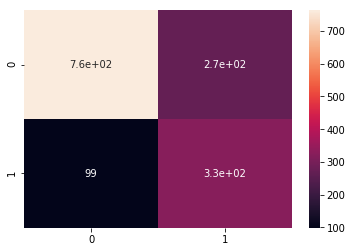

In [34]:
# Heatmap for confusion matrix
sns.heatmap(confusion_mat_lr, annot = True)

### Decision Tree

### Random Forest